In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch

# Objective
This notebook reproduces Lesson 3 "Titani in Excel" approach to build simple NN model from scracth.
* Part1: 1 and 2 layer model using PyTorch autograd and manually implemented Gradient Descent
* Part2: the same but with pure numpy+scipy implementation using scipy solver

## Data
* train dataset downloaded from https://www.kaggle.com/competitions/titanic/data?select=train.csv

## Preprocessing
Preprocessing implemented as in lecture
* remove all rows with missing values
* max normalise Age
* log(1+x) normalise Fare
* dummy vars for Pclass, Sex, Embarked

# 1. Load & filter data

In [3]:
df = pd.read_csv("data/titanic_train.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df = df.set_index('PassengerId')

In [6]:
columns_used_for_modelling = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df = df[columns_used_for_modelling].copy()

In [7]:
# remove all missing
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [8]:
df = df.dropna()
print(df.shape)

(712, 8)


# 2. Preprocess features

## 2.1 Pclass dummies

In [9]:
df['Pclass'].value_counts()

3    355
1    184
2    173
Name: Pclass, dtype: int64

In [10]:
df['Pclass_1'] = (df['Pclass'] == 1).astype(int)
df['Pclass_2'] = (df['Pclass'] == 2).astype(int)

In [11]:
df = df.drop('Pclass', axis=1)

## 2.2 Embarked dummies

In [12]:
df['Embarked'].value_counts()

S    554
C    130
Q     28
Name: Embarked, dtype: int64

In [13]:
df['Embarked_S'] = (df['Embarked'] == 'S').astype(int)
df['Embarked_C'] = (df['Embarked'] == 'C').astype(int)

In [14]:
assert df['Embarked_S'].sum() == 554
assert df['Embarked_C'].sum() == 130

In [15]:
df = df.drop('Embarked', axis=1)

## 2.3 Sex dummy -> Male

In [16]:
df['Sex'].value_counts()

male      453
female    259
Name: Sex, dtype: int64

In [17]:
df['Male'] = (df['Sex'] == 'male').astype(int)

In [18]:
assert df['Male'].sum() == 453

In [19]:
df = df.drop('Sex', axis=1)

## 2.4 Age normalisation

In [20]:
df['Age_N'] = df['Age'] / df['Age'].max()

<AxesSubplot:>

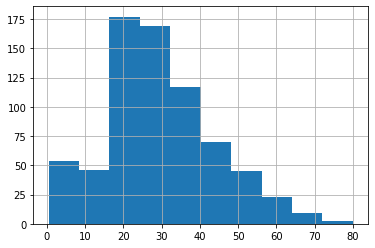

In [21]:
df['Age'].hist()

<AxesSubplot:>

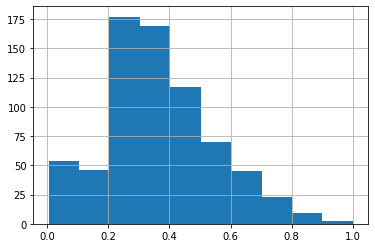

In [22]:
df['Age_N'].hist()

In [23]:
df = df.drop('Age', axis=1)

## 2.5 Fare log normalisation

In [24]:
df['Fare'].describe()

count    712.000000
mean      34.567251
std       52.938648
min        0.000000
25%        8.050000
50%       15.645850
75%       33.000000
max      512.329200
Name: Fare, dtype: float64

<AxesSubplot:>

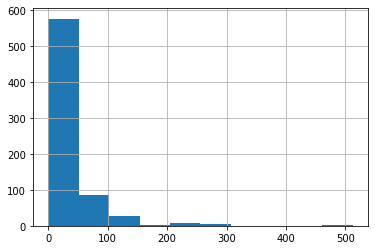

In [25]:
df['Fare'].hist()

In [26]:
df['Fare_Log'] = np.log(1+df['Fare'])

<AxesSubplot:>

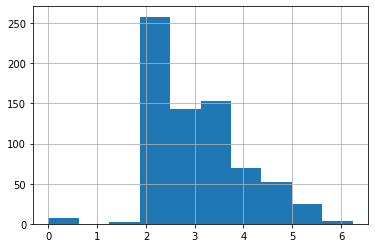

In [27]:
df['Fare_Log'].hist()

In [28]:
df = df.drop('Fare', axis=1)

## 2.6 Add artifical column for intercept

In [29]:
df['Intercept'] = 1

# 3. Get train data as matrix

In [30]:
y = df['Survived'].values

In [31]:
print("target rate", y.mean())

target rate 0.4044943820224719


In [32]:
X_df = df.drop('Survived', axis=1)
X = X_df.values

In [33]:
X.shape

(712, 10)

In [34]:
feature_names = [c for c in X_df.columns]
feature_names

['SibSp',
 'Parch',
 'Pclass_1',
 'Pclass_2',
 'Embarked_S',
 'Embarked_C',
 'Male',
 'Age_N',
 'Fare_Log',
 'Intercept']

# 4. Torch-based implementation

## 4.1 test torch operations

In [35]:
def relu(params, X):
    return torch.clip(X@params, 0)

In [36]:
def mae_loss(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    return (y_true - y_pred).abs().mean()

In [37]:
x_test = torch.tensor([[0.,1.,0.],[1, 0, 1]], dtype=torch.float64)
x_test

tensor([[0., 1., 0.],
        [1., 0., 1.]], dtype=torch.float64)

In [38]:
p_test = torch.tensor(np.reshape([1.,2.,-3.], newshape=(3,1)), dtype=torch.float64)
p_test

tensor([[ 1.],
        [ 2.],
        [-3.]], dtype=torch.float64)

In [39]:
y_test = torch.tensor([[1],[0]], dtype=torch.float64)
y_test

tensor([[1.],
        [0.]], dtype=torch.float64)

In [40]:
x_test @ p_test

tensor([[ 2.],
        [-2.]], dtype=torch.float64)

In [41]:
y_pred_test = relu(p_test, x_test)
y_pred_test

tensor([[2.],
        [0.]], dtype=torch.float64)

In [42]:
assert y_pred_test.shape == (2,1)

In [43]:
assert y_pred_test.equal(torch.tensor([[2],[0]], dtype=torch.float64))

In [44]:
loss_test = mae_loss(y_test, y_pred_test)
loss_test

tensor(0.5000, dtype=torch.float64)

In [45]:
y_test

tensor([[1.],
        [0.]], dtype=torch.float64)

In [46]:
y_pred_test

tensor([[2.],
        [0.]], dtype=torch.float64)

In [47]:
assert loss_test == 0.5 

## 4.2 Convert data to tensors 

In [48]:
n_features = X.shape[1]

In [49]:
Xt = torch.tensor(X, dtype=torch.float64)
yt = torch.tensor(y.reshape(-1,1), dtype=torch.float64)

In [50]:
Xt.shape

torch.Size([712, 10])

In [51]:
yt.shape

torch.Size([712, 1])

## 4.3 Gradient descent with single relu

In [52]:
np.random.seed(4)
m_params = torch.tensor(np.random.normal(size=(n_features, 1)), requires_grad=True)
m_params.shape

torch.Size([10, 1])

In [53]:
m_params

tensor([[ 0.0506],
        [ 0.5000],
        [-0.9959],
        [ 0.6936],
        [-0.4183],
        [-1.5846],
        [-0.6477],
        [ 0.5986],
        [ 0.3323],
        [-1.1475]], dtype=torch.float64, requires_grad=True)

In [54]:
# introduce class for a model, so we can experiment with different internals but the same optmisation loop
class Model:
    def __init__(self, relu_params):
        self.relu_params = relu_params
        
    def apply(self, X):
        return relu(self.relu_params, X)

In [55]:
model = Model(m_params)

In [56]:
n_epochs = 200
learning_rate = 0.05
learning_trace = []
for i in range(n_epochs):
    y_pred = model.apply(Xt)
    loss = mae_loss(yt, y_pred)
    loss.backward()
    with torch.no_grad():
        model.relu_params -= model.relu_params.grad * learning_rate
    model.relu_params.grad.zero_()
    if i%100 == 0:
        print(f"# {i}: loss: {loss:.5f}")
    loss_val = loss.detach().numpy().tolist()
    learning_trace.append((i,loss_val))
trace_df = pd.DataFrame.from_records(learning_trace, columns=['iter','loss']).set_index('iter')

# 0: loss: 0.40885
# 100: loss: 0.36057


In [57]:
fimp = pd.DataFrame({'f':feature_names,'coeff':model.relu_params.detach().numpy().reshape((-1,))})
fimp

,f,coeff
0,SibSp,-0.113834
1,Parch,-0.013672
2,Pclass_1,-0.990080
3,Pclass_2,0.952025
4,Embarked_S,-0.287122
5,Embarked_C,-1.579732
6,Male,-0.955783
7,Age_N,0.545415
8,Fare_Log,0.366747
9,Intercept,-1.047828


<AxesSubplot:xlabel='iter'>

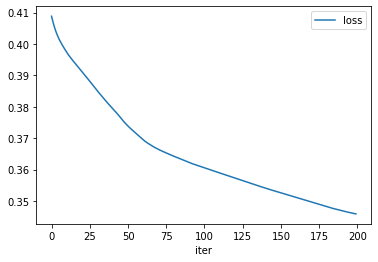

In [58]:
trace_df.plot()

count    712.000000
mean       0.088140
std        0.258782
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.339687
Name: score, dtype: float64

<AxesSubplot:>

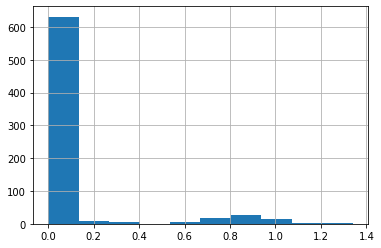

In [59]:
df['score'] = model.apply(Xt).detach().numpy().reshape((-1,))
display(df['score'].describe())
df['score'].hist()

In [60]:
df['predicted'] = (df['score'] > 0.5).astype(int)
print("accuracy",(df['Survived'] == df['predicted']).mean())

accuracy 0.672752808988764


## 4.2 Gradient descent with multiple weighted ReLu's

### 4.2.1 test the model

In [61]:
# introduce class for a model, so we can experiment with different internals but the same optmisation loop
class MutipleReluModel:
    def __init__(self, relu_params, weights):
        if relu_params.shape[1] != weights.shape[0]:
            raise ValueError("Number of parameters doesn't match weights")
        self.relu_params = relu_params
        self.weights = weights
        
    def apply(self, X):
        return relu(self.relu_params, X) @ self.weights
    
    def update_params(self, learning_rate):
        with torch.no_grad():
            self.relu_params -= self.relu_params.grad * learning_rate
            self.weights -= self.weights.grad * learning_rate
        self.relu_params.grad.zero_()
        self.weights.grad.zero_()

In [62]:
x_test = torch.tensor([[0.,1.,0.],[1, 0, 1]], dtype=torch.float64)
x_test

tensor([[0., 1., 0.],
        [1., 0., 1.]], dtype=torch.float64)

In [63]:
relu_test = torch.tensor(np.reshape([[1.,2.,-3., 10, -20, 30]], newshape=(3,2), order='F'), dtype=torch.float64)
relu_test

tensor([[  1.,  10.],
        [  2., -20.],
        [ -3.,  30.]], dtype=torch.float64)

In [64]:
w_test = torch.tensor([[1],[0.1]], dtype=torch.float64)

In [65]:
relu(relu_test, x_test) @ w_test

tensor([[2.],
        [4.]], dtype=torch.float64)

In [66]:
m_test = MutipleReluModel(relu_test, w_test)

In [67]:
y_pred_test = m_test.apply(x_test)
y_pred_test

tensor([[2.],
        [4.]], dtype=torch.float64)

In [68]:
assert y_pred_test.equal(torch.tensor([[2],[4]], dtype=torch.float64))

### 4.2.2 optimisation loop

In [69]:
np.random.seed(42)
N_RELU = 2
relu_params = torch.tensor(np.random.normal(size=(n_features, N_RELU)), requires_grad=True)
weight_params = torch.tensor(np.random.normal(size=(N_RELU, 1)), requires_grad=True)

In [70]:
model_nr = MutipleReluModel(relu_params, weight_params)

# 0: loss: 0.51127
# 100: loss: 0.32784
# 200: loss: 0.29540
# 300: loss: 0.27046
# 400: loss: 0.25225
# 500: loss: 0.24275
# 600: loss: 0.23775
# 700: loss: 0.23533
# 800: loss: 0.23353
# 900: loss: 0.23191


<AxesSubplot:xlabel='iter'>

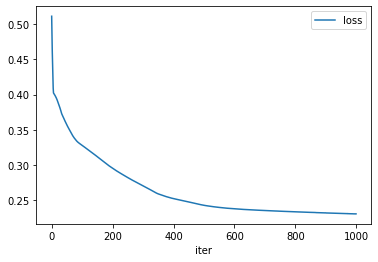

In [71]:
n_epochs = 1000
learning_rate = 0.1
learning_trace = []
for i in range(n_epochs):
    y_pred = model_nr.apply(Xt)
    loss = mae_loss(yt, y_pred)
    loss.backward()
    model_nr.update_params(learning_rate)
    if i%100 == 0:
        print(f"# {i}: loss: {loss:.5f}")
    loss_val = loss.detach().numpy().tolist()
    learning_trace.append((i,loss_val))
trace_df = pd.DataFrame.from_records(learning_trace, columns=['iter','loss']).set_index('iter')
trace_df.plot()

In [72]:
model_nr.weights

tensor([[1.4656],
        [0.4851]], dtype=torch.float64, requires_grad=True)

count    712.000000
mean       0.254325
std        0.408563
min        0.000000
25%        0.000000
50%        0.000000
75%        0.323236
max        1.569779
Name: score, dtype: float64

<AxesSubplot:>

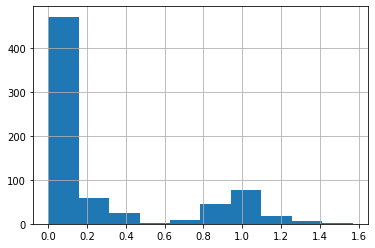

In [73]:
df['score'] = model_nr.apply(Xt).detach().numpy().reshape((-1,))
display(df['score'].describe())
df['score'].hist()

In [74]:
df['predicted'] = (df['score'] > 0.5).astype(int)
print("accuracy",(df['Survived'] == df['predicted']).mean())

accuracy 0.7907303370786517


# 5. Numpy + Scipy solver

In [75]:
from scipy.optimize import minimize

## 5.1 solver primer with a vector

In [76]:
def f(x):
    return (x[0]-1)**2 + (x[1]-2)**2 

In [77]:
res = minimize(f, np.array([0.5, -0.5]))
res

      fun: 2.1469322675083307e-15
 hess_inv: array([[ 0.98076923, -0.09615385],
       [-0.09615385,  0.51923077]])
      jac: array([-7.72782467e-08,  5.37825051e-09])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([0.99999995, 2.        ])

## 5.2 Single layer

In [78]:
def relu_np(params, X):
    return np.clip(np.dot(X , params), 0, None)

In [79]:
def mae_loss_np(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    return np.abs(y_true - y_pred).mean()

In [80]:
X.shape

(712, 10)

In [81]:
y.shape

(712,)

In [82]:
np.random.seed(4)
m_params = np.random.normal(size=n_features)
m_params

array([ 0.05056171,  0.49995133, -0.99590893,  0.69359851, -0.41830152,
       -1.58457724, -0.64770677,  0.59857517,  0.33225003, -1.14747663])

In [100]:
def loss_to_minimise(params_vect):
    # I use global variables for simplicity
    # in real life it's better to create partial(calc_loss, X, y)
    m_params = params_vect.reshape((-1,1))
    y_pred = relu_np(m_params, X)
    loss = mae_loss_np(y, y_pred.reshape(-1))
    return loss

In [101]:
y.shape

(712,)

In [102]:
loss_to_minimise(m_params)

0.40884744844451937

In [103]:
solution = minimize(loss_to_minimise, m_params, tol=1e-4)

In [104]:
solution

      fun: 0.22231149710821868
 hess_inv: array([[ 4.44238581e-03,  1.70567880e-05, -1.09936480e+00,
         1.34711304e+00, -3.30569024e+00, -3.28421461e+00,
         7.80337515e+00,  1.81578070e-01,  4.04260736e-03,
         1.88669511e+00],
       [ 1.70567880e-05,  1.70459200e-03, -3.87162577e-01,
         4.72449473e-01, -1.15965846e+00, -1.14280120e+00,
         2.74261469e+00,  6.63648094e-02,  6.08160441e-04,
         6.62351642e-01],
       [-1.09936480e+00, -3.87162577e-01,  6.30677801e+02,
        -7.67694929e+02,  1.88824392e+03,  1.87880710e+03,
        -4.47072459e+03, -1.05145342e+02, -3.00737840e+00,
        -1.07685214e+03],
       [ 1.34711304e+00,  4.72449473e-01, -7.67694929e+02,
         9.36823842e+02, -2.30278391e+03, -2.29121745e+03,
         5.45044808e+03,  1.28179279e+02,  3.65578866e+00,
         1.31272374e+03],
       [-3.30569024e+00, -1.15965846e+00,  1.88824392e+03,
        -2.30278391e+03,  5.66365739e+03,  5.63532716e+03,
        -1.34063322e+04, -3.

In [105]:
solution.x

array([ 1.56000457e-03,  1.32185957e-03,  6.53368079e-01,  6.06498770e-01,
        2.75931452e+00,  2.73462553e+00, -1.23108262e+01, -2.29061065e-01,
       -1.56381639e-02, -2.24614458e+00])

In [106]:
# solution is quite sensitive to the initial guess (random seed)
print("Final loss:",loss_to_minimise(solution.x))

Final loss: 0.22231149710821868


In [107]:
params_optimised = solution.x.reshape((-1,1))

count    712.000000
mean       0.267802
std        0.403966
min        0.000000
25%        0.000000
50%        0.000000
75%        0.432725
max        1.086394
Name: score, dtype: float64

<AxesSubplot:>

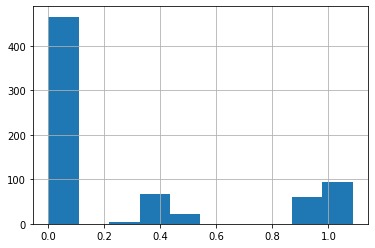

In [108]:
df['score'] = relu_np(params_optimised, X)
display(df['score'].describe())
df['score'].hist()

In [109]:
df['predicted'] = (df['score'] > 0.5).astype(int)
print("accuracy",(df['Survived'] == df['predicted']).mean())

accuracy 0.7879213483146067
